# Exploring the FDA's database of adverse event reports:   <br/> Exploratory Data Analysis (1)

[Explain the dataset here. How is the data comiled, where does it come from, what kind of data does it contain.]

In [1]:
import collect_data 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import (FormatStrFormatter)
import numpy as np
import math
import json
plt.style.use('seaborn')

url_base = "https://api.fda.gov/drug/event.json?search=receivedate:[20030101+TO+20200528]"

The number of reports over time since 2003 is 11901711.


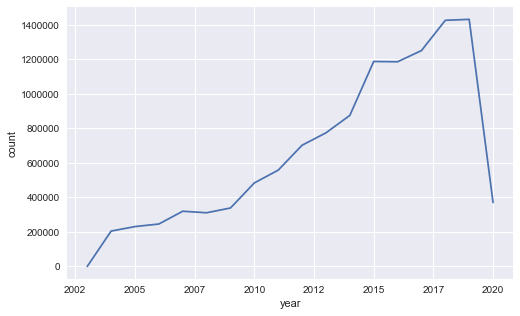

In [2]:
data = collect_data.get_data_from_url(url_base, count='receivedate')
#data = collect_data.get_data_from_url(url)
pd.to_datetime(data['time'], yearfirst = True)
data['year']=pd.DatetimeIndex(data['time']).year
ax = data.groupby('year').sum().reset_index().plot(x='year', y='count', figsize=(8, 5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_ylabel('count')
ax.get_legend().remove()
total_reports = data['count'].sum()
print(f"The number of reports over time since {data['year'].min()} is {total_reports}.")

The total number of countries in the database is 235 with a total of 8482854 reports.
However, we limit to only those countries with at least 50 reports reducing the total number of countries to 134 with a total of 8481473 reports.


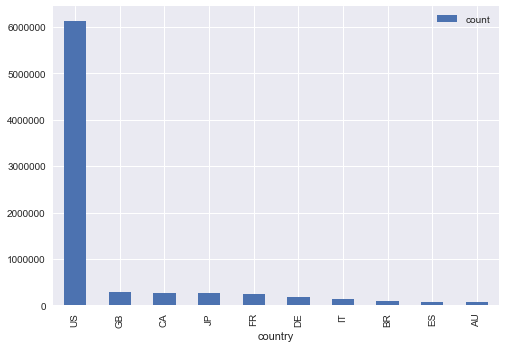

In [3]:
url = collect_data.create_search_url(
    url_base, 
    limit=300, 
    count="occurcountry.exact"
)
countries = collect_data.get_data_from_url(url)
print(f"The total number of countries in the database is {countries['count'].count()} " 
      f"with a total of {countries['count'].sum()} reports.")
countries = countries.loc[countries['count']>50,:]
countries.rename(columns={'term' : 'country'}, inplace=True)
print(f"However, we limit to only those countries with at least 50 reports "
      f"reducing the total number of countries to {countries['count'].count()} "
      f"with a total of {countries['count'].sum()} reports.")

for country in countries['country']:
    url = collect_data.create_search_url(
        url_base, search_key='occurcountry.exact', search_term=country, count="patient.reaction.reactionmeddrapt.exact"
        )
    
countries.head(10).plot.bar(x='country',y='count');

The top 50 adverse reports make up 88.7% of the total.


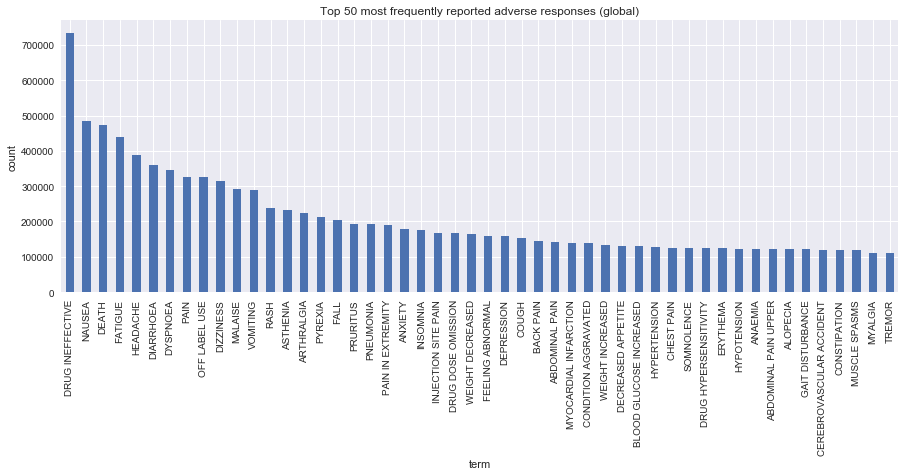

In [4]:
adverse_effects = collect_data.get_data_from_url(url_base, 
                                                 limit=50, 
                                                 count="patient.reaction.reactionmeddrapt.exact")
ax = adverse_effects.plot.bar(x='term', y='count', figsize=(15, 5))
ax.set_ylabel('count')
ax.get_legend().remove()
print(f"The top 50 adverse reports make up {100*adverse_effects['count'].sum()/total_reports:.1f}% of the total.")
plt.title("Top 50 most frequently reported adverse responses (global)");

## Investigate age


There are 1381585 reports with specified patient age groups in the database.


,term,count,age_group
4,1,14007,Neonate
5,2,9174,Infant
2,3,35325,Child
3,4,25009,Adolescent
0,5,819073,Adult
1,6,478997,Elderly


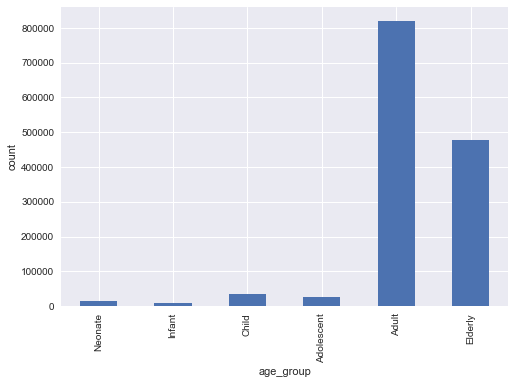

In [5]:
data = collect_data.get_data_from_url(url_base, 
                                      count="patient.patientagegroup")
num_patient_age_reports = data['count'].sum()
print(f"There are {num_patient_age_reports} reports with specified patient age groups in the database.")
data.sort_values('term',inplace=True)
age_group_map = {1 : 'Neonate',
                 2 : 'Infant',
                 3 : 'Child',
                 4 : 'Adolescent',
                 5 : 'Adult',
                 6 : 'Elderly'}
data['age_group'] = data['term'].map(age_group_map)
ax = data.plot.bar(x='age_group',y='count')
ax.get_legend().remove()
ax.set_ylabel('count')

# check total number of reports with no patient age + no reports with patient age equals total number report
url = collect_data.create_search_url(url_base, 
                                     search_key='_missing_', 
                                     search_term='patient.patientagegroup', 
                                     count="receivedate")
test_data = collect_data.get_data_from_url(url)
assert num_patient_age_reports + test_data['count'].sum() == total_reports, "Inconsistent queries."
data.head(10)

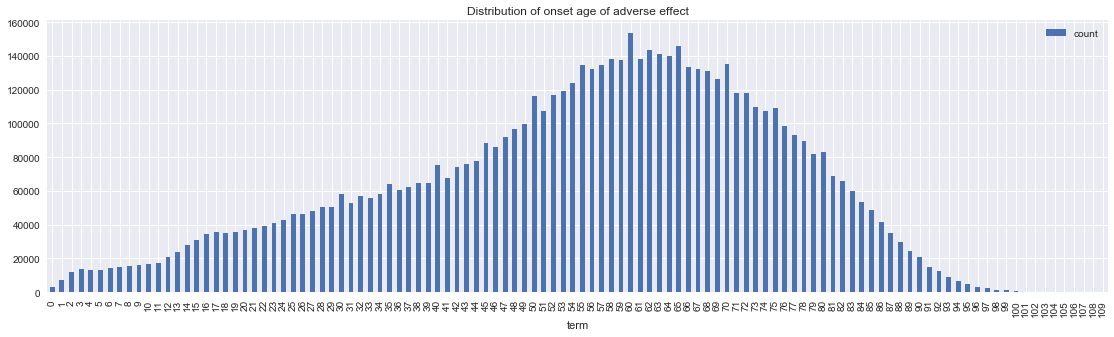

In [6]:
# search for all patient onsetages sepcified in years (801)
# comprises 97% of all data
data = collect_data.get_data_from_url(url_base, 
                                      search_key='patient.patientonsetageunit', 
                                      search_term='801', 
                                      count="patient.patientonsetage", 
                                      sort="patient.patientonsetage", 
                                      limit=1000)
data.sort_values('term', inplace=True)
# drop reports with unrealistic ages from dataframe
data = data[data['term']<110]
ax = data.plot.bar(x='term',y='count',figsize=(19,5));
ax.set_title('Distribution of onset age of adverse effect');

## Severity of adverse effects

We can consider the severity of adverse effects. At the simplest level, an adverse effect is classified as either serious (where the adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition), or 'not serious' (where the adverse event did not result in any of these). </br>

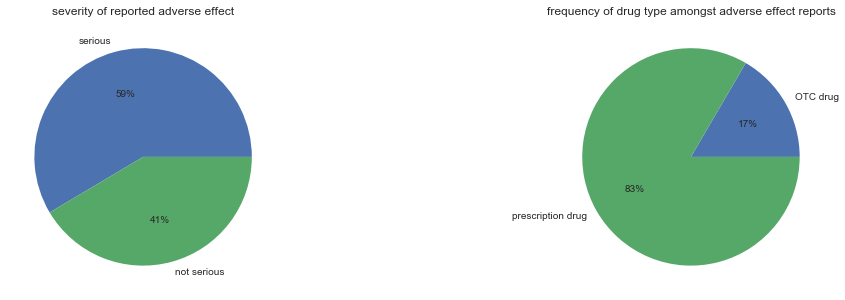

In [7]:
# collect necessary data
data = collect_data.get_data_from_url(url_base, search_key='serious', search_term='1', count='patient.drug.openfda.product_type.exact')
data['severity']=1
data2 = collect_data.get_data_from_url(url_base, search_key='serious', search_term='2', count='patient.drug.openfda.product_type.exact')
data2['severity']=2
data = data.append(data2)
data.rename(columns={'term' : 'drug type'}, inplace=True)

# construct pivot table
cont_table = data.pivot_table(values='count', index=data["drug type"], columns=['severity'],aggfunc='sum')
cont_table = 100*cont_table/data['count'].sum()
cont_table.rename(columns={1:'serious',2:'not serious'}, inplace=True)

# plot pie charts of global frequency of severity and drug type
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,5))
ax1 = cont_table.sum().plot.pie(autopct='%1.0f%%',ax=ax1);
ax1.set_ylabel('');
ax1.set_title('severity of reported adverse effect')
ax2 = cont_table.sum(axis=1).plot.pie(autopct='%1.0f%%',ax=ax2, labels=['OTC drug','prescription drug'])
ax2.set_title('frequency of drug type amongst adverse effect reports')
ax2.set_ylabel('');


It is easy to see that the majority of reports in the database resulted in serious adverse effects, perhaps beacuse clinicians and patients are less inclined to go to the effort of submitting reports for less severe cases. We can also see that the significant majority of adverse reports are due prescription drugs as opposed to over-the-counter (OTC) mdeications. It possible to understand how these two factos relate to each other using a contingency table.

In [8]:
cont_table

severity,serious,not serious
drug type,,
HUMAN OTC DRUG,9.752508,6.841004
HUMAN PRESCRIPTION DRUG,48.784197,34.622291


The values indicate the percentage of reports that fall into each category. Somewhat surprisingly, the ratio of serious adverse effects to not serious adverse effects is simlar for both OTC and prescription medication.

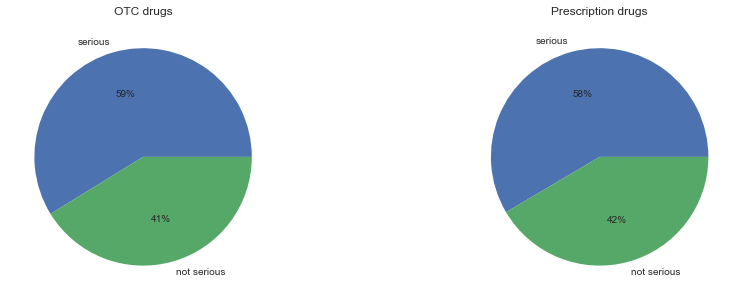

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax1 = cont_table.loc['HUMAN OTC DRUG',:].plot.pie(autopct='%1.0f%%',ax=ax1);
ax1.set_ylabel('');
ax1.set_title('OTC drugs');
ax2 = cont_table.loc['HUMAN PRESCRIPTION DRUG',:].plot.pie(autopct='%1.0f%%',ax=ax2);
ax2.set_ylabel('');
ax2.set_title('Prescription drugs');

We can perform a similar analysis for other properties of the delivered medicine. For example, let's consider a more complex contingency table with different levels of severity considered against different drug indications.

In [10]:
serious_outcomes = ['congenitalanomali','death','hospitalization','disabling','lifethreatening','other']
for i, outcome in enumerate(serious_outcomes):
    search_str = 'seriousness' + outcome
    sub_data = collect_data.get_data_from_url(url_base, search_key=search_str, search_term='1', count='patient.drug.openfda.route.exact', limit=1000)
    sub_data.rename(columns={'count' : outcome}, inplace=True)
    if i==0:
        data = sub_data
    else:
        data = pd.merge(data, sub_data, how="outer", on="term")
data = data.fillna(0)
data['total']=data.sum(axis=1)
data['fraction']=data['total'].divide(data['total'].sum())
data.sort_values(by=['total'], inplace=True, ascending=False)
data = data.set_index('term')
data.head(10).style.format("{:,.0f}")
#assert data['fraction'].sum()==1, 'Fraction calculation incorrect.'

,congenitalanomali,death,hospitalization,disabling,lifethreatening,other,total,fraction
term,,,,,,,,
ORAL,"38,678","785,472","1,979,893","183,962","254,748","2,735,117","5,977,870",0
INTRAVENOUS,"14,673","457,061","1,109,459","94,757","157,618","1,469,330","3,302,898",0
SUBCUTANEOUS,"6,771","202,192","566,898","38,320","61,183","828,736","1,704,100",0
INTRAMUSCULAR,"8,264","192,790","539,869","51,727","74,313","657,113","1,524,076",0
TOPICAL,"2,705","95,439","276,037","24,723","42,218","350,749","791,871",0
RECTAL,"1,626","82,430","241,558","19,234","31,937","237,130","613,915",0
OPHTHALMIC,"1,156","55,942","158,438","15,727","25,589","207,612","464,464",0
RESPIRATORY (INHALATION),944,"40,790","146,974","10,009","16,373","168,643","383,733",0
INTRATHECAL,700,"35,619","111,652","8,862","15,050","173,724","345,607",0


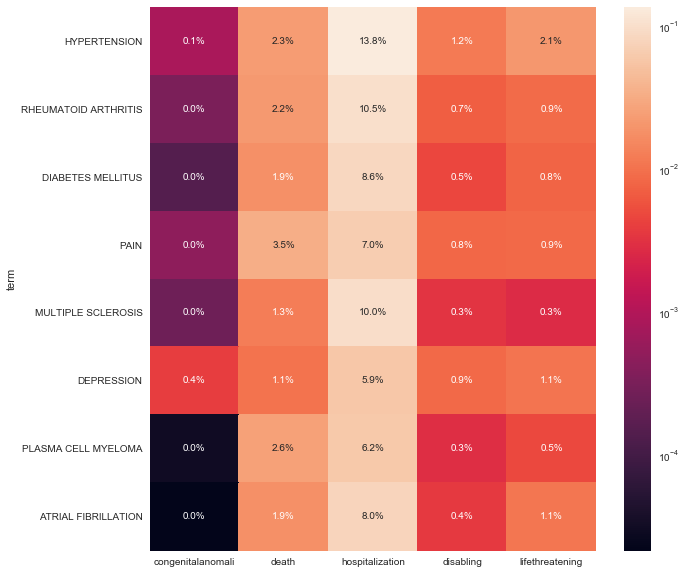

In [15]:
# consider only the main delivery routes (i.e. those indicated in >1% of reports)
sub_data = data.loc[:,'congenitalanomali':'lifethreatening'].head(8)
total_count = (sub_data.sum().sum())
sub_data = sub_data.divide(total_count)
fig = plt.figure(figsize=(10,10));
ax = sns.heatmap(sub_data,
                 norm=LogNorm(vmin=sub_data.min().min(), vmax=sub_data.max().max()),
                 annot=True,
                fmt='.1%');
assert 0.999 <= sub_data.sum().sum() <= 1.001, "Percentage calculation incorrect."

We can see from the heatmap that oral and intravenous delivery routes are the most prevalent. We can also see that where serious adverse side effects arise, and are identified, there is no particular correlation between the drug delivery route and the nature of the adverse response.

In [12]:
serious_outcomes = ['congenitalanomali','death','hospitalization','disabling','lifethreatening','other']
#data = pd.DataFrame()
for i, outcome in enumerate(serious_outcomes):
    search_str = 'seriousness' + outcome
    sub_data = collect_data.get_data_from_url(url_base, search_key=search_str, search_term='1', count='patient.drug.drugindication.exact', limit=1000)
    sub_data.rename(columns={'count' : outcome}, inplace=True)
    if i==0:
        data = sub_data
    else:
        data = pd.merge(data, sub_data, how="outer", on="term")
data = data.fillna(0)
data.set_index('term', inplace=True)
data = data.drop('PRODUCT USED FOR UNKNOWN INDICATION')
data = data.drop('DRUG USE FOR UNKNOWN INDICATION')
data['total']=data.sum(axis=1)
data['fraction']=data['total'].divide(data['total'].sum())
data.sort_values(by=['total'], inplace=True, ascending=False)
assert 0.999 <= data['fraction'].sum() <= 1.001, "Percentage calculation incorrect."
data.head(10).style.format("{:,.0f}")

,congenitalanomali,death,hospitalization,disabling,lifethreatening,other,total,fraction
term,,,,,,,,
HYPERTENSION,974,"26,915","158,320","13,533","24,403","161,383","385,528",0
RHEUMATOID ARTHRITIS,395,"25,294","120,202","8,307","10,448","205,240","369,886",0
DIABETES MELLITUS,171,"21,715","99,034","5,426","8,993","109,914","245,253",0
PAIN,570,"39,811","79,889","9,710","9,966","98,282","238,228",0
MULTIPLE SCLEROSIS,298,"14,696","114,819","3,857","3,136","94,661","231,467",0
DEPRESSION,"4,586","12,168","67,415","10,088","12,227","96,649","203,133",0
PLASMA CELL MYELOMA,36,"30,132","71,559","3,336","5,644","85,907","196,614",0
ATRIAL FIBRILLATION,25,"21,243","91,661","4,305","12,744","49,429","179,407",0
PROPHYLAXIS,337,"20,159","62,126","4,030","10,949","61,057","158,658",0


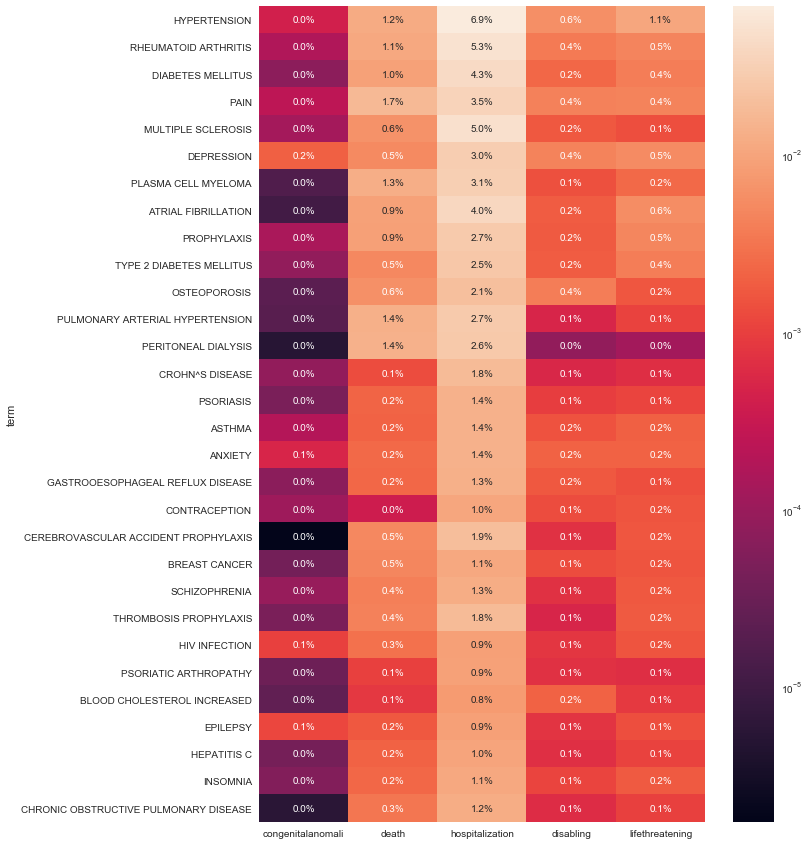

In [13]:
sub_data = data.loc[:,'congenitalanomali':'lifethreatening'].head(30)
total_count = (sub_data.sum().sum())
sub_data = sub_data.divide(total_count)
fig = plt.figure(figsize=(10,15));
ax = sns.heatmap(sub_data,
                 norm=LogNorm(vmin=sub_data.min().min(), vmax=sub_data.max().max()),
                 annot=True,fmt='.1%');